<a href="https://colab.research.google.com/github/Tom1611/Tom-Vurt/blob/main/starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌦️ WeatherWise – Starter Notebook

Welcome to your **WeatherWise** project notebook! This scaffold is designed to help you build your weather advisor app using Python, visualisations, and AI-enhanced development.

---

📄 **Full Assignment Specification**  
See [`ASSIGNMENT.md`](ASSIGNMENT.md) or check the LMS for full details.

📝 **Quick Refresher**  
A one-page summary is available in [`resources/assignment-summary.md`](resources/assignment-summary.md).

---

🧠 **This Notebook Structure is Optional**  
You’re encouraged to reorganise, rename sections, or remove scaffold cells if you prefer — as long as your final version meets the requirements.

✅ You may delete this note before submission.



## 🧰 Setup and Imports

This section imports commonly used packages and installs any additional tools used in the project.

- You may not need all of these unless you're using specific features (e.g. visualisations, advanced prompting).
- The notebook assumes the following packages are **pre-installed** in the provided environment or installable via pip:
  - `requests`, `matplotlib`, `pyinputplus`
  - `fetch-my-weather` (for accessing weather data easily)
  - `hands-on-ai` (for AI logging, comparisons, or prompting tools)

If you're running this notebook in **Google Colab**, uncomment the following lines to install the required packages.


In [185]:
!pip install requests ipywidgets matplotlib ipyleaflet geopy pyinputplus --quiet
!pip install fetch-my-weather
!pip install hands-on-ai

In [186]:
import os

# --- AI Setup ---
os.environ['HANDS_ON_AI_SERVER'] = 'http://ollama.serveur.au'
os.environ['HANDS_ON_AI_MODEL'] = 'granite3.2'
os.environ['HANDS_ON_AI_API_KEY'] = '913d9b3e94be4cb5a56dedcd7fe9f8ac'

# --- Weather API Setup ---
BASE_URL = 'https://api.openweathermap.org/data/2.5/'
API_KEY = '913d9b3e94be4cb5a56dedcd7fe9f8ac'

# --- Global Defaults ---
user_preferences = {"units": "metric"}
weather_data = None

## 📦 Setup and Configuration
Import required packages and setup environment.

In [187]:
import requests
import matplotlib.pyplot as plt
import pyinputplus as pyip

# Import after installing (if needed)
from fetch_my_weather import get_weather
from hands_on_ai.chat import get_response

# Interface & Visualization
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipyleaflet import Map, Marker

# Geocoding services
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderServiceError
from datetime import datetime, timedelta



## 🌤️ Weather Data Functions

In [188]:
# Define get_weather_data() function here
def get_weather_data(location, forecast_days=5):
    """
    Retrieve weather data for a specified location.

    Args:
        location (str): City or location name
        forecast_days (int): Number of days to forecast (1-5)

    Returns:
        dict: Weather data including current conditions and forecast
    """

#display_welcome()

def launch_weatherwise():
    clear_output(wait=True)
    print("🌤️ Welcome to WeatherWise Advisor")
    print("Get accurate forecasts, insights, and advice at your fingertips.\n")
    get_location_method()


def is_valid_location(location):
    return bool(location and len(location.strip()) > 2)


import time

def get_weather_data(location, forecast_days=5, units='metric'):
    """
    Fetch current and forecast weather data from OpenWeatherMap.
    """

    time.sleep(0.7)  # simulate loading
    current_url = f"{BASE_URL}weather?q={location}&appid={API_KEY}&units={units}"
    forecast_url = f"{BASE_URL}forecast?q={location}&appid={API_KEY}&units={units}&cnt={forecast_days * 8}"

    current_response = requests.get(current_url)
    forecast_response = requests.get(forecast_url)

    if current_response.status_code == 200 and forecast_response.status_code == 200:
        current = current_response.json()
        temp = current['main']['temp']
        desc = current['weather'][0]['description']
        humidity = current['main']['humidity']
        wind = current['wind']['speed']
        unit = "°C" if units == "metric" else "°F"


        return {
            'current': current_response.json(),
            'forecast': forecast_response.json()
        }
    else:
        print("⚠️ Unable to retrieve data — please recheck your city name or internet connection.")
        return None


# ✅ LOCATION SELECTION
def get_location_method():
    clear_output(wait=True)
    display_welcome()

    method_selector = widgets.ToggleButtons(
        options=[('🖊️ Input City Name', 'manual'), ('🗺️ Select from Map', 'map')],
        description='📍 How would you like to set your location?',
        style={'description_width': 'initial'},
    )
    continue_button = widgets.Button(
        description="Next➡️",
        button_style='primary',
        layout=widgets.Layout(width='auto')
    )

    def on_continue_clicked(_):
        method = method_selector.value
        clear_output(wait=True)
        if method == 'manual':
            manual_location_input()
        elif method == 'map':
            map_location_input()

    continue_button.on_click(on_continue_clicked)
    display(method_selector, continue_button)


# ✅ MANUAL INPUT
def manual_location_input():
    global user_preferences
    default_city = user_preferences.get("last_city", "")

    location_input = widgets.Text(
        value=default_city,
        description="🌍 City name:",
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='auto')
    )

    confirm_button = widgets.Button(
        description="Confirm",
        button_style='success',
        layout=widgets.Layout(width='auto')
    )

    def on_confirm_clicked(_):
        global user_preferences
        location = location_input.value
        validation_data = get_weather_data(location, units=user_preferences.get("units", "metric"))
        if validation_data:
            get_preferred_units(location)
        else:
            clear_output(wait=True)
            print("🚫 City not found. Please check spelling and try again.")
            manual_location_input()

    confirm_button.on_click(on_confirm_clicked)
    display(location_input, confirm_button)


# ✅ MAP INPUT
def map_location_input():
    m = Map(center=(20, 0), zoom=2)
    marker = Marker()
    m.add_layer(marker)

    instructions = widgets.Label("🗺️ Click anywhere on the map to set your location.")

    def handle_map_click(**kwargs):
        if kwargs.get('type') == 'click':
            latlon = kwargs.get('coordinates')
            if not latlon:
                return
            lat, lon = latlon
            marker.location = (lat, lon)
            get_location_name_from_coordinates(lat, lon)

    m.on_interaction(handle_map_click)
    display(instructions, m)


# ✅ GEOLOCATION
def get_location_name_from_coordinates(lat, lon):
    geolocator = Nominatim(user_agent="weatherwise")
    try:
        location = geolocator.reverse((lat, lon), timeout=10)
        if location and location.address:
            addr = location.raw.get('address', {})
            city_name = (
                addr.get('city')
                or addr.get('town')
                or addr.get('village')
                or addr.get('state')
            )
            if city_name:
                get_preferred_units(city_name)
            else:
                print("⚠️ Could not detect city name. Try typing manually.")
                get_location_method()
        else:
            print("⚠️ Could not determine city name. Try again.")
            get_location_method()
    except (GeocoderTimedOut, GeocoderServiceError):
        print("⏳ Map service timeout. Please try again shortly.")
        get_location_method()


# ✅ UNIT SELECTION
def get_preferred_units(location):
    unit_selector = widgets.ToggleButtons(
        options=[('🌡️ Celsius (°C)', 'metric'), ('🔥 Fahrenheit (°F)', 'imperial')],
        description='Choose temperature unit:',
        style={'description_width': 'initial'}
    )

    confirm_btn = widgets.Button(description="Continue ➡️", button_style='primary')

    def on_confirm(_):
        global user_preferences, weather_data
        user_preferences['units'] = unit_selector.value
        clear_output(wait=True)

        # ✅ FIXED: Removed duplicate printing inside this section
        weather_data = get_weather_data(location, units=user_preferences['units'])
        print(f"✅ Location successfully set: {location}")
        app = WeatherWiseApp(location)
        app.display_current_weather()

    confirm_btn.on_click(on_confirm)
    display(unit_selector, confirm_btn)

## 📊 Visualisation Functions

In [201]:
# Define create_temperature_visualisation() and create_precipitation_visualisation() here
def create_temperature_visualisation(weather_data, output_type='display'):
    """
    Create visualisation of temperature data.

    Args:
        weather_data (dict): The processed weather data
        output_type (str): Either 'display' to show in notebook or 'figure' to return the figure

    Returns:
        If output_type is 'figure', returns the matplotlib figure object
        Otherwise, displays the visualisation in the notebook
    """
def create_temperature_visualisation(weather_data, output_type='display'):
    temps = []
    times = []
    for entry in weather_data['forecast']['list']:
        temps.append(entry['main']['temp'])
        times.append(entry['dt_txt'])

    plt.figure(figsize=(10, 4))
    plt.plot(times, temps, marker='o')
    plt.title('Temperature Forecast')
    plt.xlabel('Date & Time')
    plt.ylabel(f"Temperature ({'°C' if user_preferences['units'] == 'metric' else '°F'})")
    plt.xticks(rotation=45)
    plt.tight_layout()

    if output_type == 'figure':
        return plt.gcf()
    else:
        plt.show()

def create_precipitation_visualisation(weather_data, output_type='display'):
    rain_amounts = []
    times = []
    for entry in weather_data['forecast']['list']:
        rain = entry.get('rain', {}).get('3h', 0)
        rain_amounts.append(rain)
        times.append(entry['dt_txt'])

    plt.figure(figsize=(10, 4))
    plt.bar(times, rain_amounts)
    plt.title('Precipitation Forecast')
    plt.xlabel('Date & Time')
    plt.ylabel('Rain (mm)')
    plt.xticks(rotation=45)
    plt.tight_layout()

    if output_type == 'figure':
        return plt.gcf()
    else:
        plt.show()



IndentationError: expected an indented block after 'else' statement on line 31 (ipython-input-4055943663.py, line 34)

In [190]:

def create_precipitation_visualisation(weather_data, output_type='display'):
    """
    Create visualisation of precipitation data.

    Args:
        weather_data (dict): The processed weather data
        output_type (str): Either 'display' to show in notebook or 'figure' to return the figure

    Returns:
        If output_type is 'figure', returns the matplotlib figure object
        Otherwise, displays the visualisation in the notebook
    """
    pass

## 🤖 Natural Language Processing

In [191]:
# Define parse_weather_question() and generate_weather_response() here
def parse_weather_question(question):
    """
    Parse a natural language weather question.

    Args:
        question (str): User's weather-related question

    Returns:
        dict: Extracted information including location, time period, and weather attribute
    """
def parse_weather_question(question):
    """
    Parses the user's question into structured reasoning and decides the tool or action.
    """
    reasoning = f"Analyzing the question: '{question}'."
    tools = []

    lower_question = question.lower()

    if any(word in lower_question for word in ['temperature', 'hot', 'cold', 'degree']):
        attribute = 'temperature'
        tools.append('fetch_current_weather')
    elif any(word in lower_question for word in ['rain', 'precipitation', 'umbrella', 'wet']):
        attribute = 'rain'
        if "forecast" in lower_question or "next days" in lower_question:
            tools.append('show_precipitation_forecast')
        else:
            tools.append('fetch_current_weather')
    elif any(word in lower_question for word in ['wind', 'breeze', 'gust']):
        attribute = 'wind'
        tools.append('fetch_current_weather')
    elif any(word in lower_question for word in ['hike', 'hiking', 'safe']):
        attribute = 'hiking'
        tools.append('evaluate_hiking_condition')
    elif any(word in lower_question for word in ['forecast', 'next days']):
        attribute = 'forecast'
        tools.append('show_temperature_forecast')
    else:
        attribute = 'unknown'
        tools.append('clarify_question')

    parsed = {
        'reasoning': reasoning,
        'attribute': attribute,
        'tools': tools
    }

    return parsed

def generate_weather_response(parsed_question, weather_data):
    """
    Generates a response by executing the chosen tools based on parsed reasoning.
    """
    attribute = parsed_question['attribute']
    tools = parsed_question['tools']
    reasoning = parsed_question['reasoning']

    # Add ReAct-style thinking trace
    print(f"[Reasoning] {reasoning}")
    print(f"[Action] Tools selected: {tools}")

    current = weather_data['current']
    forecast = weather_data['forecast']  # kept for potential future use
    temp_unit = "°C" if user_preferences['units'] == 'metric' else "°F"

    response = ""

    for tool in tools:
        if tool == 'fetch_current_weather':
            weather_desc = current.get('weather', [{}])[0].get('description', 'N/A')
            temp = current.get('main', {}).get('temp', 'N/A')
            wind = current.get('wind', {}).get('speed', 'N/A')
            humidity = current.get('main', {}).get('humidity', 'N/A')

            if attribute == 'temperature':
                response += f"The current temperature is {temp}{temp_unit} with {weather_desc}.\n"
            elif attribute == 'rain':
                response += f"Currently, the weather is '{weather_desc}'. You might want to grab an umbrella before heading out!\n"
            elif attribute == 'wind':
                response += f"Winds are blowing at roughly {wind} m/s.\n"
            else:
                response += f"The weather is currently {weather_desc} with temperature {temp}{temp_unit}.\n"

        elif tool == 'show_temperature_forecast':
            fig = create_temperature_visualisation(weather_data, output_type='figure')
            response += "Here's the temperature forecast for the next days.\n"
            display(fig)

        elif tool == 'show_precipitation_forecast':
            fig = create_precipitation_visualisation(weather_data, output_type='figure')
            response += "Here's the expected rain forecast for the upcoming period.\n"
            display(fig)

        elif tool == 'evaluate_hiking_condition':
            weather_desc = current.get('weather', [{}])[0].get('description', 'N/A')
            wind = current.get('wind', {}).get('speed', 10)
            if weather_desc in ['clear sky', 'few clouds'] and wind < 5:
                response += "✅ Perfect day for a hike! Clear sky and gentle wind.\n"
            else:
                response += "⚠️ Conditions aren’t great for hiking today — best to stay in.\n"

        elif tool == 'clarify_question':
            response += "❓ I need a bit more information. Could you rephrase your question?\n"

        else:
            response += "⚙️ The system could not find the right action for your question.\n"

    return response

def create_temperature_visualisation(weather_data, output_type='display'):
    temps = []
    times = []
    for entry in weather_data['forecast']['list']:
        temps.append(entry['main']['temp'])
        times.append(entry['dt_txt'])

    plt.figure(figsize=(10, 4))
    plt.plot(times, temps, marker='o')
    plt.title('Temperature Forecast')
    plt.xlabel('Date & Time')
    plt.ylabel(f"Temperature ({'°C' if user_preferences['units'] == 'metric' else '°F'})")
    plt.xticks(rotation=45)
    plt.tight_layout()

    if output_type == 'figure':
        return plt.gcf()
    else:
        plt.show()

def create_precipitation_visualisation(weather_data, output_type='display'):
    rain_amounts = []
    times = []
    for entry in weather_data['forecast']['list']:
        rain = entry.get('rain', {}).get('3h', 0)
        rain_amounts.append(rain)
        times.append(entry['dt_txt'])

    plt.figure(figsize=(10, 4))
    plt.bar(times, rain_amounts)
    plt.title('Precipitation Forecast')
    plt.xlabel('Date & Time')
    plt.ylabel('Rain (mm)')
    plt.xticks(rotation=45)
    plt.tight_layout()

    if output_type == 'figure':
        return plt.gcf()
    else:
        plt.show()


## 🧭 User Interface

In [199]:
class WeatherWiseApp:
    def __init__(self, location=None):
        if not location:
            display_welcome()
            get_location_method()
        else:
            self.location = location
            self.weather_data = None
            self.load_weather_data()
            self.build_menu()

    def load_weather_data(self):
        data = get_weather_data(self.location, units=user_preferences.get("units", "metric"))
        if data:
            self.weather_data = data
        else:
            print("⚠️ Failed to retrieve data. Please try again later.")

    def build_menu(self):
        self.menu = widgets.Dropdown(
            options=[
                ("Select an option", 0),
                ("View current weather", 1),
                ("See weather forecast", 2),
                ("Ask a weather-related question", 3),
                ("Change location", 4),
                ("Exit WeatherWise Advisor", 5)
            ],
            description='Menu:',
            style={'description_width': 'initial'}
        )
        self.menu.observe(self.menu_handler, names='value')
        display(self.menu)

    def menu_handler(self, change):
        if change['name'] != 'value' or change['new'] == change['old']:
            return

        clear_output(wait=True)
        display(self.menu)

        if change['new'] == 1:
            self.display_current_weather()
        elif change['new'] == 2:
            self.display_forecast()
        elif change['new'] == 3:
            self.ask_question()
        elif change['new'] == 4:
            get_location_method()
        elif change['new'] == 5:
            print("⛅ Thanks for using WeatherWise! Stay sunny, stay happy, and stay weather-ready! 🌈")

    def display_current_weather(self):
        if not self.weather_data:
            print("Weather data is not available.")
            return

        current = self.weather_data['current']
        desc = current['weather'][0]['description']
        temp = current['main']['temp']
        feels_like = current['main']['feels_like']
        humidity = current['main']['humidity']
        wind = current['wind']['speed']
        temp_unit = "°C" if user_preferences['units'] == 'metric' else "°F"

        print(f"{'🌡️':2} Temperature: {temp:<5}{temp_unit} (Feels like {feels_like}{temp_unit})")
        print(f"{'🌬️':2} Wind Speed:  {wind:<5} m/s")
        print(f"{'💧':2} Humidity:    {humidity}%")
        print(f"{'☁️':2} Conditions:  {desc.capitalize()}\n")


    def display_forecast(self):
        if not self.weather_data:
            print("Weather data is not available.")
            return

        print(f"📈 Forecast for {self.location}:")
        fig1 = create_temperature_visualisation(self.weather_data, output_type='figure')
        display(fig1)

        fig2 = create_precipitation_visualisation(self.weather_data, output_type='figure')
        display(fig2)

    def ask_question(self):
        question_input = widgets.Text(
            description="Ask about the weather:",
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='auto')
        )
        ask_btn = widgets.Button(description="Ask", button_style='primary')  # Blue button

        def on_ask_clicked(_):
            question = question_input.value
            parsed_question = parse_weather_question(question)
            if parsed_question['attribute']:
                response = generate_weather_response(parsed_question, self.weather_data)
                print(f"\nAnswer: {response}")
            else:
                print("❓ I couldn't understand your question. Try asking something like 'What is the temperature?'")

        ask_btn.on_click(on_ask_clicked)
        display(question_input, ask_btn)


## 🧩 Main Application Logic

In [193]:
# Tie everything together here
def generate_weather_response(parsed_question, weather_data):
    """
    Generate a natural language response to a weather question.

    Args:
        parsed_question (dict): Parsed question data
        weather_data (dict): Weather data

    Returns:
        str: Natural language response
    """
    pass

## 🧪 Testing and Examples

In [194]:
# Include sample input/output for each function

## 🗂️ AI Prompting Log (Optional)
Add markdown cells here summarising prompts used or link to AI conversations in the `ai-conversations/` folder.

Dropdown(description='Menu:', index=2, options=(('Select an option', 0), ('View current weather', 1), ('See we…

📈 Forecast for Ha Noi:


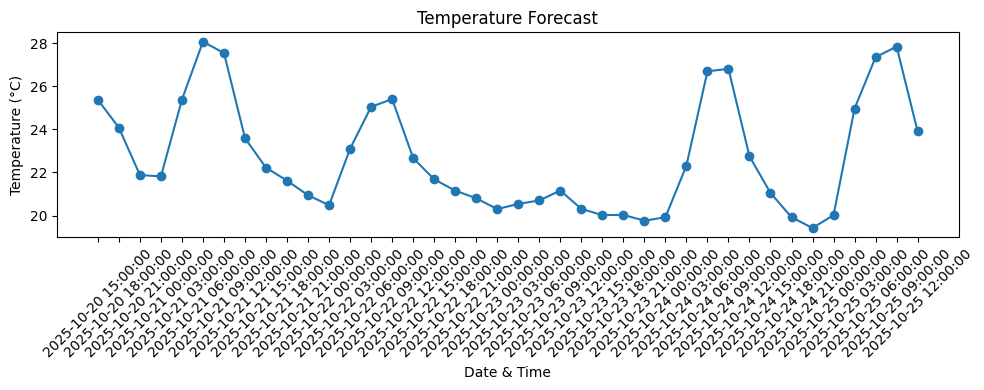

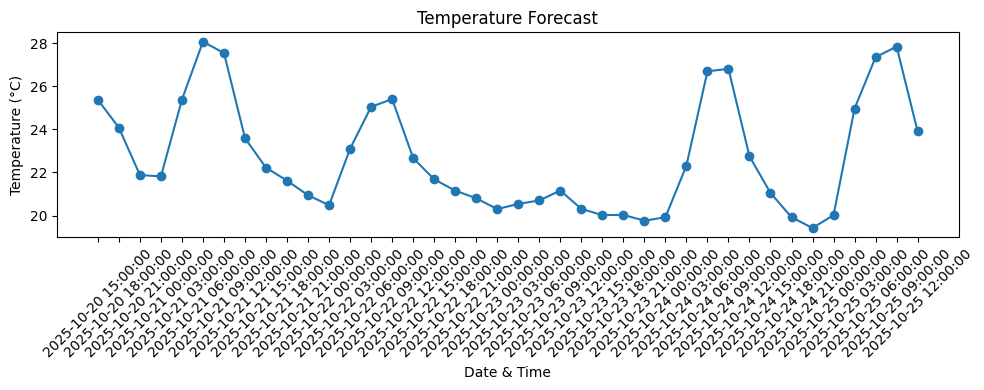

In [200]:
display_welcome()
get_location_method()
